In [1]:
from pathlib import Path

import numpy as np
import cv2
import sklearn.cluster
import matplotlib.pyplot as plt
import skimage
import pyefd

from seed_detector.tools import resample_polygon, polygon_area, get_contours as _get_contours

In [170]:
def get_contour(image, n = 200):
    bg_col = (0, 0, 0)
    bin_image = (image != bg_col).all(axis=2)

    contours, hierarchy = cv2.findContours(
        bin_image.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
    )
    contours = [c[:, -1, [1, 0]] for c in contours]
    contour = contours[0]
    contour = resample_polygon(contour, n)
    
    return contour

from scipy.linalg import orthogonal_procrustes

def match_shapes(a, b):

    a = np.array(a, dtype=np.double, copy=True)
    b = np.array(b, dtype=np.double, copy=True)
    
    a -= np.mean(a, 0)
    b -= np.mean(b, 0)

    norm1 = np.linalg.norm(a)
    norm2 = np.linalg.norm(b)
    
    a /= norm1
    b /= norm2
    
    best_rotation, best_scale = orthogonal_procrustes(a, b)
    best_disparity = np.sum(np.square(a - b.dot(best_rotation.T)))
    best_i = 0
    for i in range(1, b.shape[0]):
        cur_b = np.r_[b[i:,], b[:i,]]
        
        rot, scale = orthogonal_procrustes(a, cur_b)
        disparity = np.sum(np.square(a - cur_b.dot(rot.T)))
        # disparity = np.sum(np.abs(a - cur_b.dot(rot.T)))
        
        # print(i, disparity, best_disparity)
        
        if disparity < best_disparity:
            best_disparity = disparity
            best_rotation = rot
            best_scale = scale
            best_i = i
        
    return b.dot(best_rotation.T), best_i, best_rotation, best_scale, best_disparity

def rotate_upright(points, box_type='ellipse'):
    if box_type == 'box':
        xy, wh, angle = cv2.minAreaRect(points)
    elif box_type == 'ellipse':
        xy, wh, angle = cv2.fitEllipse(points)
    else:
        msg = f'Unknown box_type "{box_type}".'
        raise Exception(msg)
    
    
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    
    points_rot = points - points.mean(axis=0)
    points_rot = points_rot.dot(R)
    points_rot += points.mean(axis=0)
    
    return points_rot

def plot_points(xy, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(xy[:, 0], xy[:, 1])
    
def plot_box(xy, ax=None, box_type='ellipse'):
    if ax is None:
        ax = plt.gca()
    
    if box_type == 'box':
        box = cv2.minAreaRect(xy)
    elif box_type == 'ellipse':
        box = cv2.fitEllipse(xy)
    else:
        msg = f'Unknown box_type "{box_type}".'
        raise Exception(msg)
    box_xy = cv2.boxPoints(box)
    
    plot_points(box_xy)

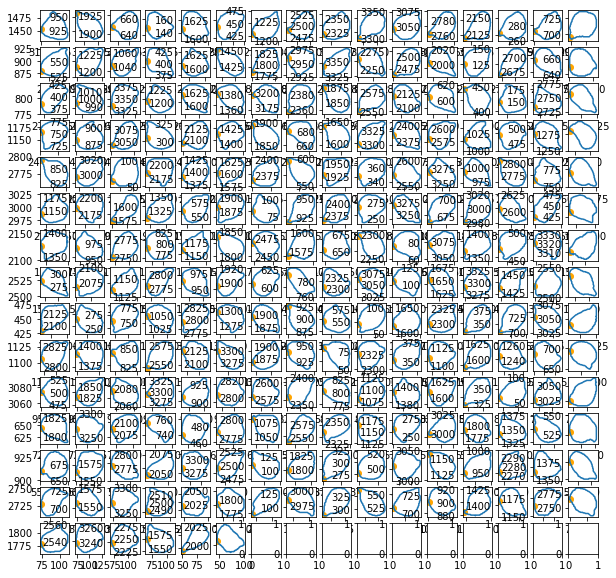

In [187]:
import seed_detector.tools as sdt

# mask_path = Path('./test/Scannen1140/Scannen1140_mask.png')
# mask_path = Path('./test/Scannen0101/Scannen0101_mask.png')
# mask_path = Path('./test/Scannen0010/Scannen0010_mask.png')
# mask_path = Path('./test/Scannen0779/Scannen0779_mask.png')
mask_path = Path('./test/Scannen0389/Scannen0389_mask.png')
mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
contours = sdt.get_contours(mask, 10)

n_contours = len(contours)

n_col = int(np.ceil(np.sqrt(n_contours)))

fig, axs = plt.subplots(int(np.ceil(n_contours / n_col)), n_col, figsize=(10, 10))
axs = axs.flatten()
for i, contour in enumerate(contours):
    axs[i].plot(contour[:, 0], contour[:, 1])
    axs[i].scatter(contour[0, 0], contour[0, 1], color='orange')

In [188]:
ref = rotate_upright(contours[0])
ref_approx = pyefd.reconstruct_contour(pyefd.elliptic_fourier_descriptors(ref, order=3, normalize=False), num_points=100)

contours_rot = [ref]
for contour in contours[1:]:
    contour_approx = pyefd.reconstruct_contour(pyefd.elliptic_fourier_descriptors(contour, order=3, normalize=False), num_points=100)
    _, best_i, rotation, scale, _ = match_shapes(ref_approx, contour_approx)
    contour_approx_rot = contour_approx.dot(rotation.T)
    disparity = np.sum(np.square(ref_approx - contour_approx_rot))

    contour_rot = contour.dot(rotation.T)
    contour_rot = np.r_[contour_rot[best_i:,], contour_rot[:best_i,]]
    contours_rot.append(contour_rot)

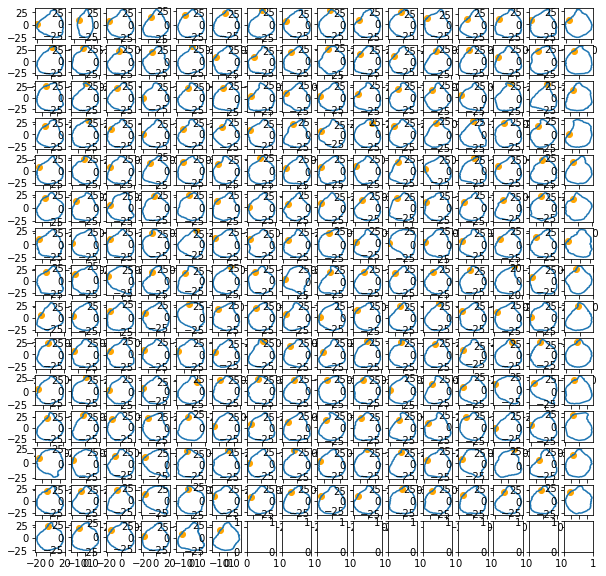

In [189]:
n_col = int(np.ceil(np.sqrt(n_contours)))

fig, axs = plt.subplots(int(np.ceil(n_contours / n_col)), n_col, figsize=(10,10))
axs = axs.flatten()
for i, contour in enumerate(contours_rot):
    c = contour - contour.mean(0)
    axs[1].axis('equal')
    axs[i].plot(c[:, 0], c[:, 1])
    axs[i].scatter(c[0, 0], c[0, 1], color='orange')

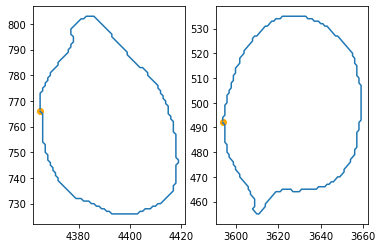

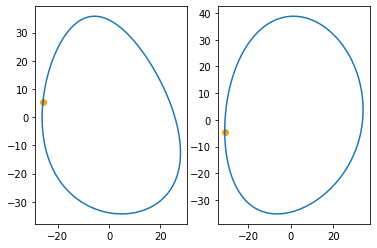

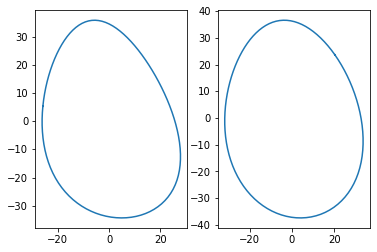

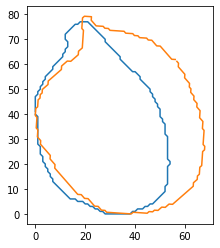

In [133]:
contour1 = contours[0]
contour2 = contours[8]

fig, axs = plt.subplots(1,2)
axs[0].plot(contour1[:, 0], contour1[:, 1])
axs[0].scatter(contour1[0, 0], contour1[0, 1], color='orange')
axs[1].plot(contour2[:, 0], contour2[:, 1])
axs[1].scatter(contour2[0, 0], contour2[0, 1], color='orange')

 
contour1_approx = pyefd.reconstruct_contour(pyefd.elliptic_fourier_descriptors(contour1, order=2, normalize=False), num_points=100)
contour2_approx = pyefd.reconstruct_contour(pyefd.elliptic_fourier_descriptors(contour2, order=2, normalize=False), num_points=100)

fig, axs = plt.subplots(1,2)
axs[0].plot(contour1_approx[:, 0], contour1_approx[:, 1])
axs[0].scatter(contour1_approx[0, 0], contour1_approx[0, 1], color='orange')
axs[1].plot(contour2_approx[:, 0], contour2_approx[:, 1])
axs[1].scatter(contour2_approx[0, 0], contour2_approx[0, 1], color='orange')

_, best_i, rotation, scale, _ = match_shapes(contour1_approx, contour2_approx)

contour1_approx_rot = contour1_approx.copy()
contour2_approx_rot = contour2_approx.dot(rotation.T)
disparity = np.sum(np.square(contour1_approx_rot - contour2_approx_rot))

fig, axs = plt.subplots(1,2)
axs[0].plot(contour1_approx_rot[:, 0], contour1_approx_rot[:, 1])
axs[1].plot(contour2_approx_rot[:, 0], contour2_approx_rot[:, 1])


fig, ax = plt.subplots(1,1)
ax.set_aspect('equal')
ax.plot(contour1[:, 0] - min(contour1[:, 0]), contour1[:, 1] - min(contour1[:, 1]))
contour2_rot = contour2.dot(rotation.T)
ax.plot(contour2_rot[:, 0] - min(contour2_rot[:, 0]), contour2_rot[:, 1] - min(contour2_rot[:, 1]))

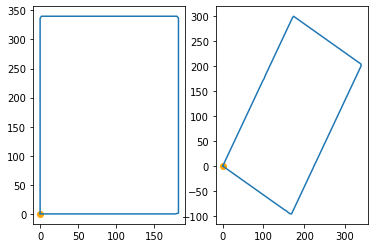

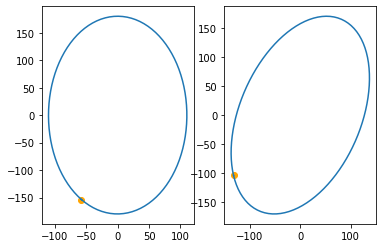

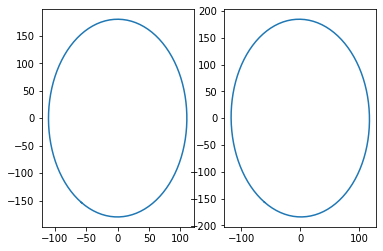

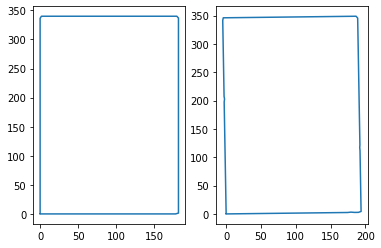

In [18]:
image_path1 = Path('./test/Scannen1140/extractions/Scannen1140_bbox0.png')
image1 = cv2.cvtColor(cv2.imread(str(image_path1)), cv2.COLOR_BGR2RGB)
contour1 = get_contour(image1)

image_path2 = Path('./test/Scannen1140/extractions/Scannen1140_bbox9.png')
image2 = cv2.cvtColor(cv2.imread(str(image_path2)), cv2.COLOR_BGR2RGB)
contour2 = get_contour(image2)
theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c,-s), (s, c)))
contour2 = contour2.dot(R)


fig, axs = plt.subplots(1,2)
axs[0].plot(contour1[:, 0], contour1[:, 1])
axs[0].scatter(contour1[0, 0], contour1[0, 1], color='orange')
axs[1].plot(contour2[:, 0], contour2[:, 1])
axs[1].scatter(contour2[0, 0], contour2[0, 1], color='orange')

 
contour1_approx = pyefd.reconstruct_contour(pyefd.elliptic_fourier_descriptors(contour1, order=2, normalize=False), num_points=100)
contour2_approx = pyefd.reconstruct_contour(pyefd.elliptic_fourier_descriptors(contour2, order=2, normalize=False), num_points=100)

fig, axs = plt.subplots(1,2)
axs[0].plot(contour1_approx[:, 0], contour1_approx[:, 1])
axs[0].scatter(contour1_approx[0, 0], contour1_approx[0, 1], color='orange')
axs[1].plot(contour2_approx[:, 0], contour2_approx[:, 1])
axs[1].scatter(contour2_approx[0, 0], contour2_approx[0, 1], color='orange')


# rotation, scale = orthogonal_procrustes(contour1_approx, contour2_approx)

# contour1_rot = contour1_approx.copy()
# contour2_rot = contour2_approx.dot(rotation.T)
# disparity = np.sum(np.square(contour1_rot - contour2_rot))


_, best_i, rotation, scale, _ = match_shapes(contour1_approx, contour2_approx)

contour1_approx_rot = contour1_approx.copy()
contour2_approx_rot = contour2_approx.dot(rotation.T)
disparity = np.sum(np.square(contour1_approx_rot - contour2_approx_rot))

fig, axs = plt.subplots(1,2)
axs[0].plot(contour1_approx_rot[:, 0], contour1_approx_rot[:, 1])
axs[1].plot(contour2_approx_rot[:, 0], contour2_approx_rot[:, 1])


fig, axs = plt.subplots(1,2)
axs[0].plot(contour1[:, 0], contour1[:, 1])
contour2_rot = contour2.dot(rotation.T)
axs[1].plot(contour2_rot[:, 0], contour2_rot[:, 1])

In [45]:
r = match_shapes(contour1_approx, np.r_[contour2_approx[5:,], contour2_approx[:5,]])